In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os

## Read the blue side data

mininum Wavelength = 3200 Angstrom   
maximum Wavelenegth = 5900 Angstrom
Number of wavelength elements: 5193

### Examples in reading and plotting one spectrum
Note: the data reduction software extracted multiple spectra from the data. Only one is useful. In this case, the spectrum is identified using idnex 5. This is case specific.

In [1]:
f = './blue/sc_SDSS1411_LS5x60x1.0_G400L_Dual_023_BFR.fits'

hdul = fits.open(f)
print(hdul.info())
hd = hdul['EXR'].header

# Establish the wavelength solution
wl_min = 3200
wl_max = 5900
n_wl = 5193
wl = np.linspace(wl_min, wl_max, n_wl)
spec = hdul['EXR1D'].data[4, :]
spec_err = hdul['EXR1D_ERROR'].data[4, :]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(wl, spec, color='black', lw=0.5)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (counts)')


NameError: name 'fits' is not defined

Note: the spikes shown in the spectrum are caused by bad pixels or cosmic rays. We can filter out these spikes by comparing with a median-filtered spectrum.

Text(0, 0.5, 'Flux (counts)')

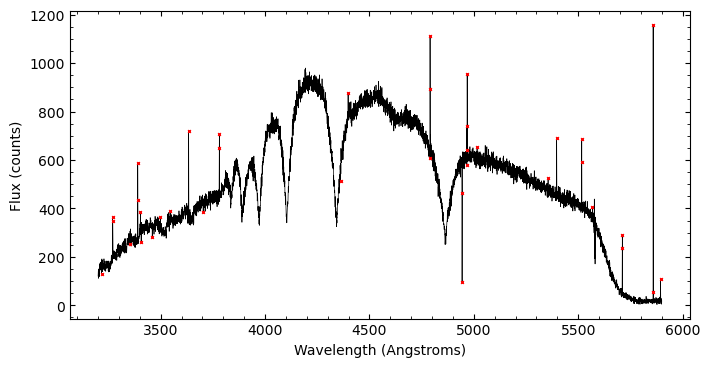

In [ ]:
from scipy.signal import medfilt
from scipy.interpolate import interp1d
filter_size = 5
sigma_thresh = 3  # use 5 sigma to identify bad pixels
# Apply a median filter to the spectrum
spec_filt = medfilt(spec.astype(float), kernel_size=5)
# Mark the pixels that are above the threshold
bad_pix_mask, = np.where(np.abs(spec - spec_filt) > sigma_thresh * spec_err)

# Show the identified bad pixels / cosmic rays
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(wl, spec, color='black', lw=0.5)
ax.plot(wl[bad_pix_mask], spec[bad_pix_mask], 'rx', markersize=2)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (counts)')

Replace these pixels using interpolation.

Text(0, 0.5, 'Flux (counts)')

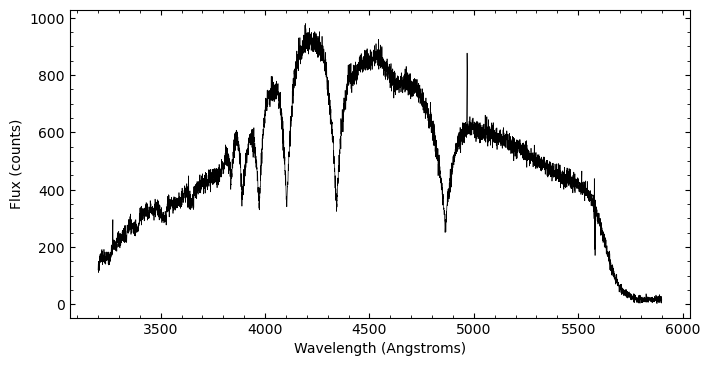

In [54]:
# Interpolate over the bad pixels
good_pix_mask = np.ones(len(spec), dtype=bool)
good_pix_mask[bad_pix_mask] = False
interp_func = interp1d(wl[good_pix_mask], spec[good_pix_mask], bounds_error=False, fill_value='extrapolate')
spec_fixed = spec.copy()
spec_fixed[bad_pix_mask] = interp_func(wl[bad_pix_mask])
# Show the spectrum after interpolation
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(wl, spec_fixed, color='black', lw=0.5)
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (counts)')

## Homework

1. Organize the code into a function so it can be easily applied to a list of files.
2. Examine the content, especially headers of FITS files: locate the following information: date and time the data was taken and the range of wavelength.
3. Extract and clean the spectra for all blue side data, range the spectra by time, identify and describe the differences.
4. Apply the same method to the red side data; repeat the above exercise.

C:\Users\ecpav\AppData\Local\Temp\ipykernel_32280\2828451493.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))


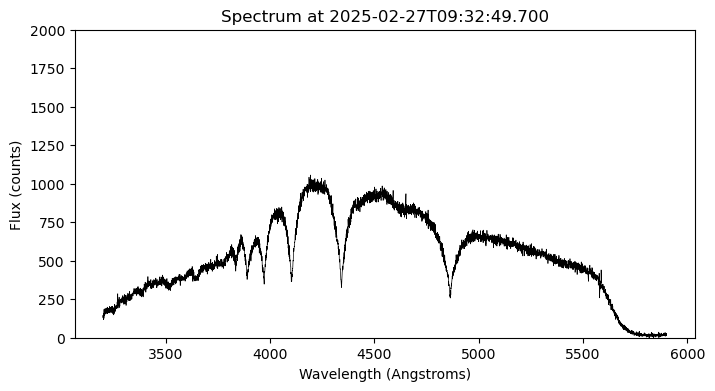

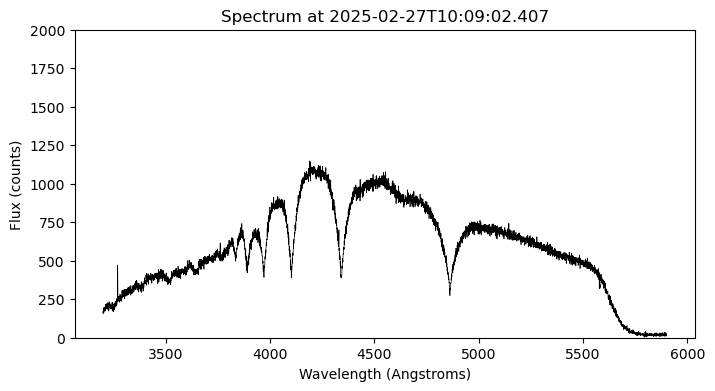

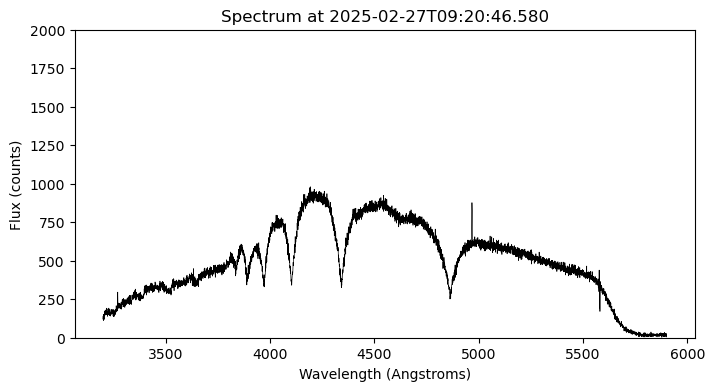

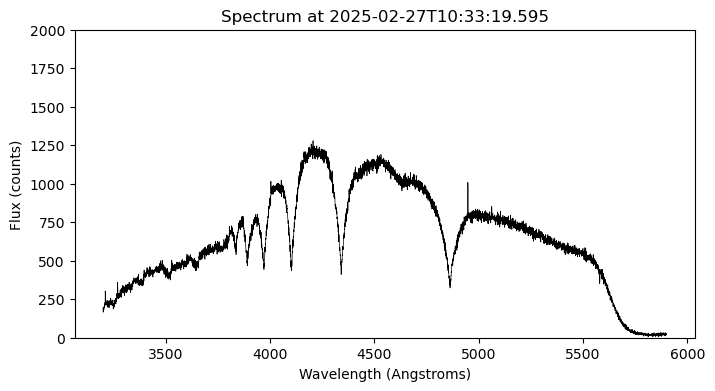

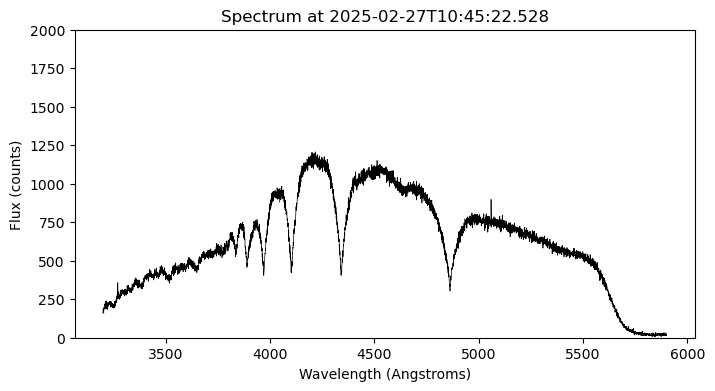

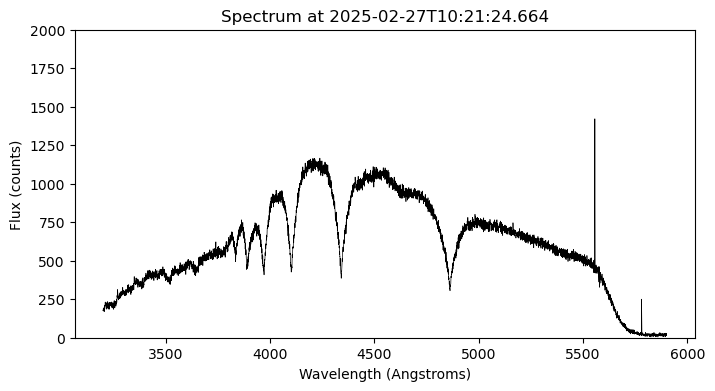

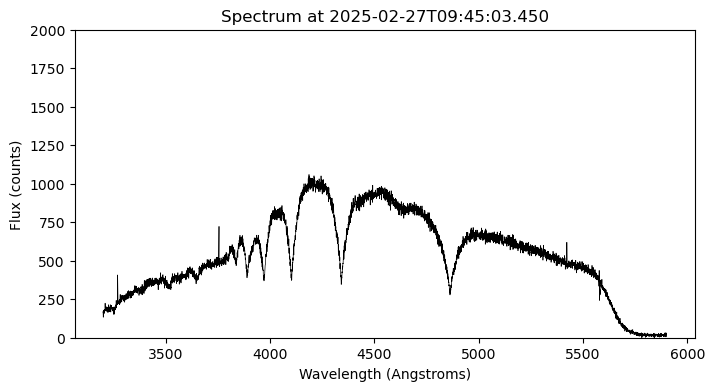

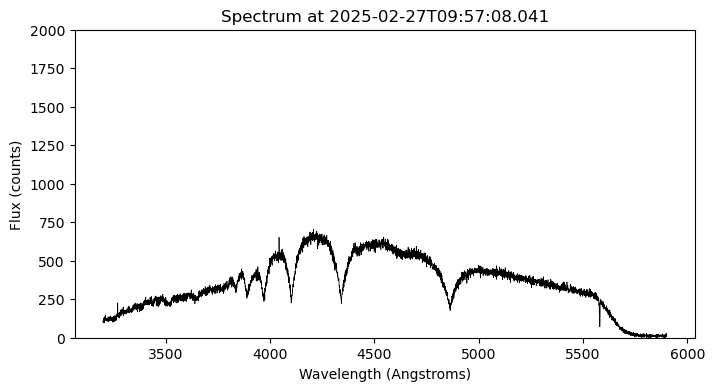

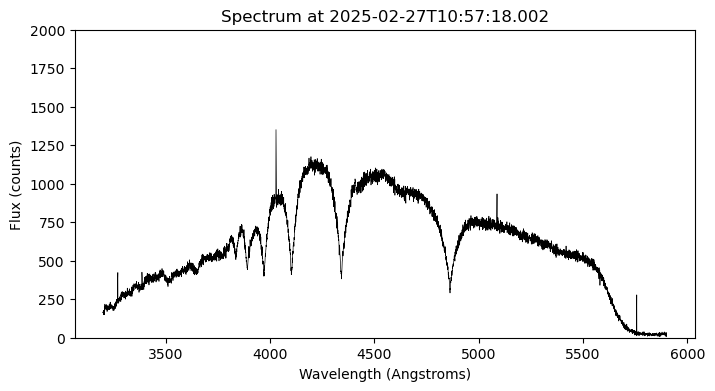

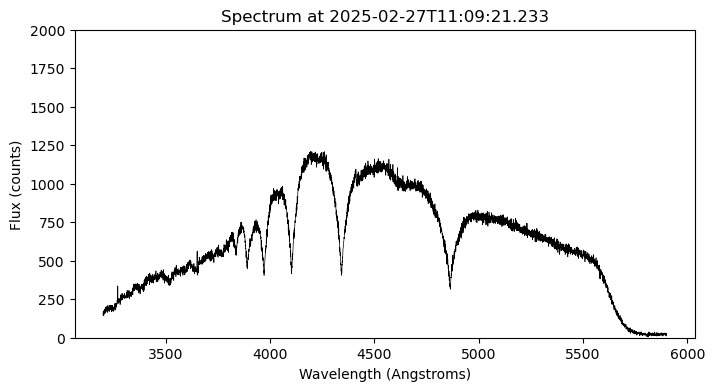

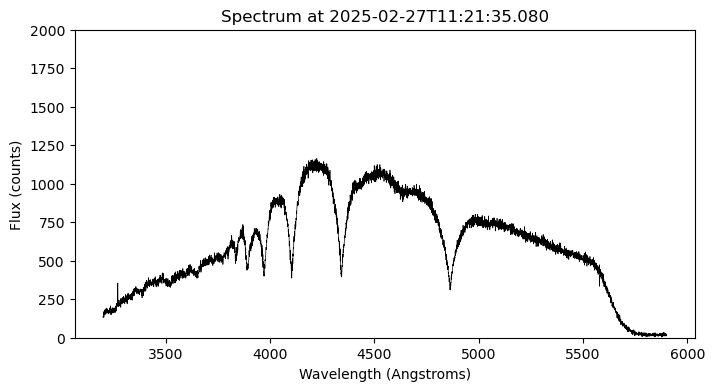

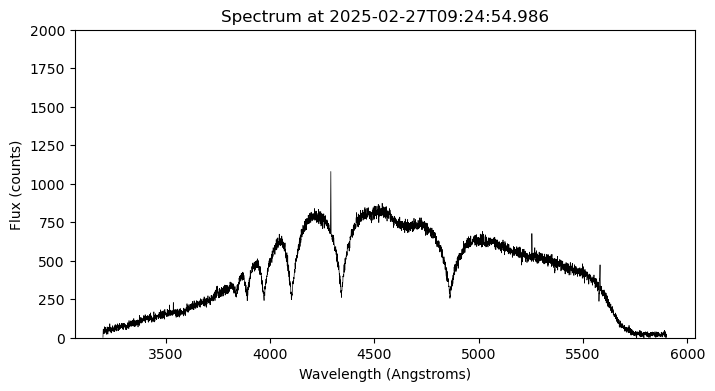

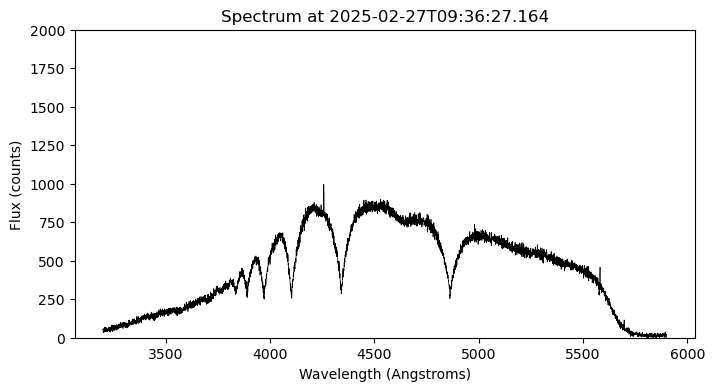

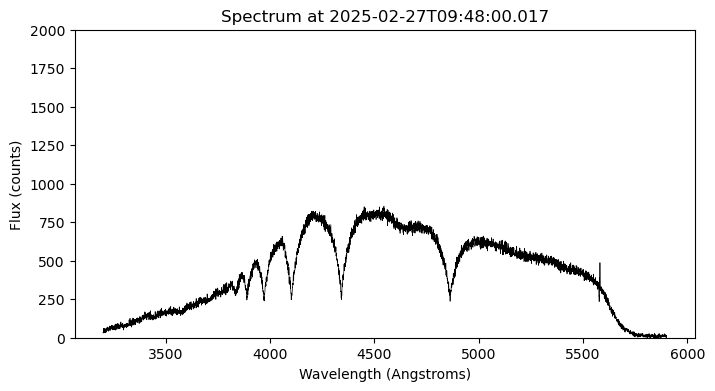

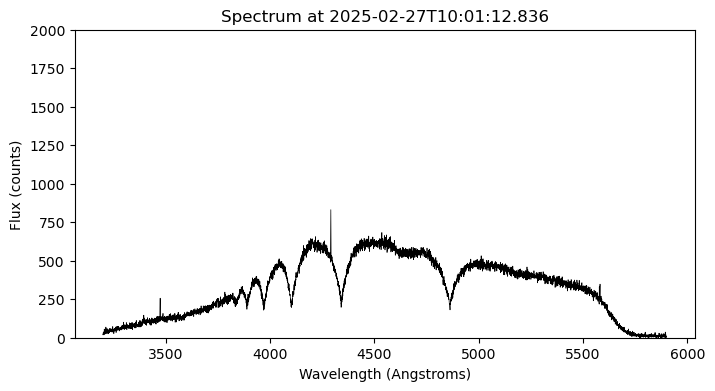

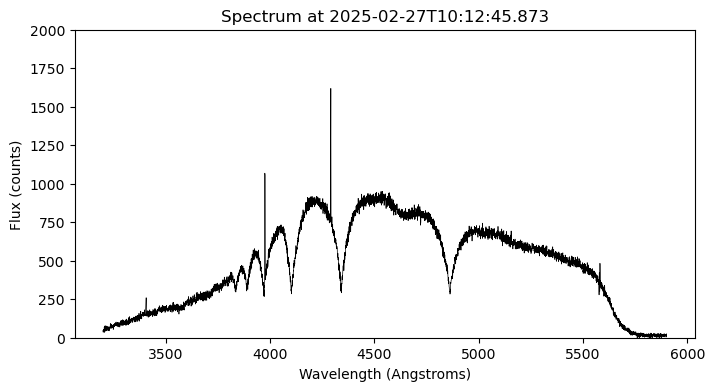

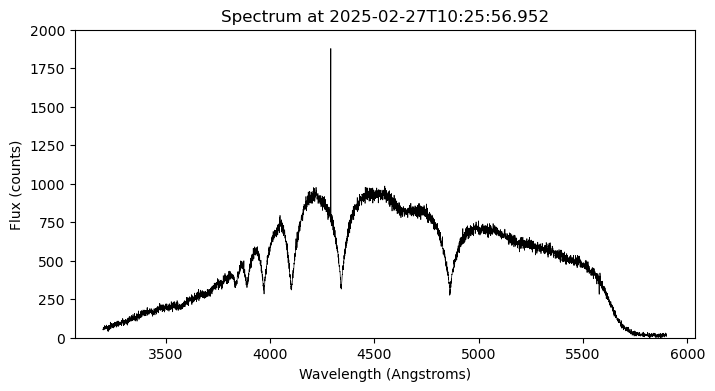

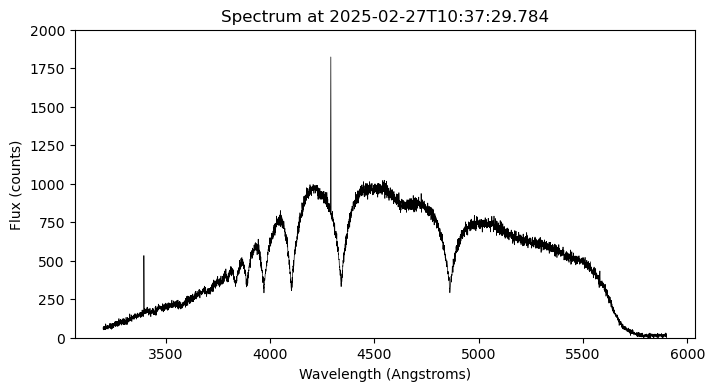

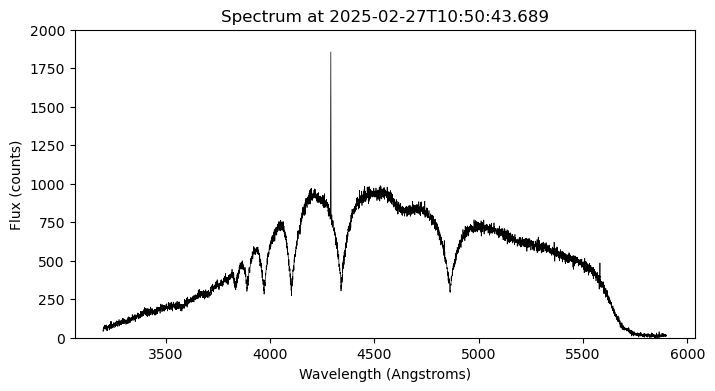

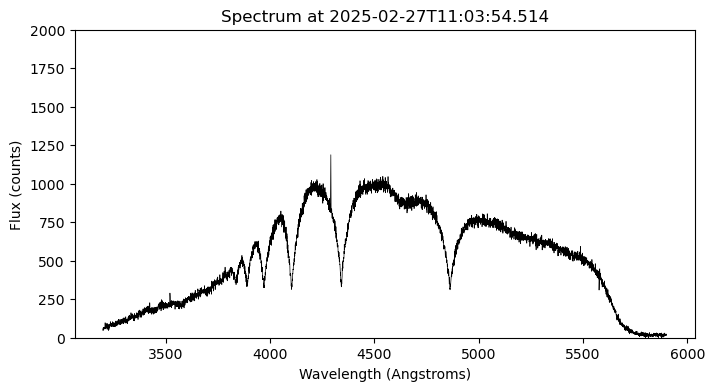

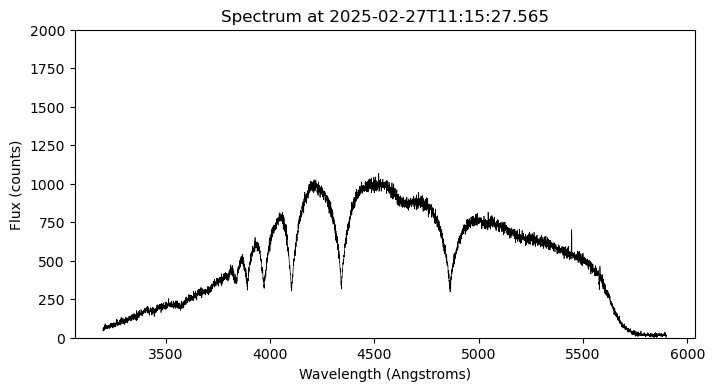

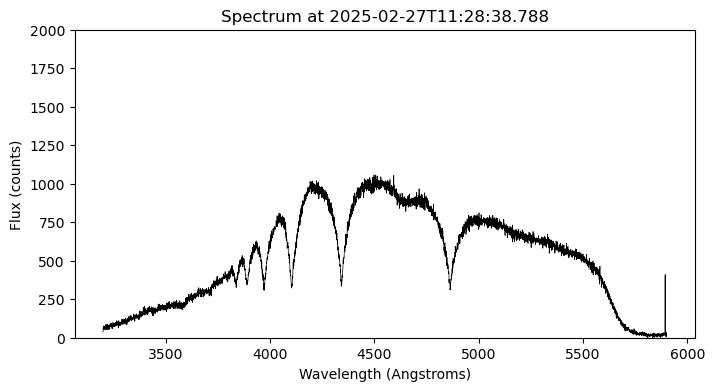

In [6]:
def process_zipped_fits_folder(zip_path):
    """
    Process all FITS files in a zipped folder and plot their spectra.

    Parameters:
        zip_path (str): path to the zipped folder containing the FITS files
    """
    import zipfile
    import io

    with zipfile.ZipFile(zip_path) as zipf:
        for filename in zipf.namelist():
            if filename.lower().endswith('.fits'):
                with zipf.open(filename) as file:
                    with fits.open(io.BytesIO(file.read())) as hdul:
                        load_and_plot_spectrum(hdul)


def load_and_plot_spectrum(hdul):
    """
    Loads a MODS FITS file, extracts the spectrum, and plots it.

    Parameters:
        filename (str): path to the FITS file
    """
    from astropy.io import fits
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from scipy.signal import medfilt
    from scipy.interpolate import interp1d

    # Open FITS file
    # print(hdul.info())
    hd = hdul['EXR'].header
    spec_data = hdul['EXR1D'].data
    spec_err_data = hdul['EXR1D_ERROR'].data
    
    # Select the spectrum with the highest mean flux because the index won't work for the specs of all the fits files
    mean_fluxes = [np.mean(s) for s in spec_data]
    best_index = np.argmax(mean_fluxes)
    spec = spec_data[best_index]
    spec_err = spec_err_data[best_index]

    # Get wavelength calibration info / Establish the wavelength solution
    wl_min = 3200
    wl_max = 5900
    n_wl = len(spec)
    wl = np.linspace(wl_min, wl_max, n_wl)

    filter_size = 5
    sigma_thresh = 3  # use 3 sigma to identify bad pixels
    # Apply a median filter to the spectrum
    spec_filt = medfilt(spec.astype(float), kernel_size=5)
    # Mark the pixels that are above the threshold
    bad_pix_mask = np.where((np.abs(spec - spec_filt) > sigma_thresh * spec_err))

    # Interpolate over the bad pixels
    good_pix_mask = np.ones(len(spec), dtype=bool)
    good_pix_mask[bad_pix_mask] = False
    interp_func = interp1d(wl[good_pix_mask], spec[good_pix_mask], bounds_error=False, fill_value='extrapolate')
    spec_fixed = spec.copy()
    spec_fixed[bad_pix_mask] = interp_func(wl[bad_pix_mask])
    
    # Show the spectrum after interpolation
    obs_time = hdul[0].header.get('DATE-OBS', 'Unknown Time')
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(wl, spec_fixed, color='black', lw=0.5)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Flux (counts)')
    ax.set_title(f"Spectrum at {obs_time}")

process_zipped_fits_folder('blue.zip')

C:\Users\ecpav\AppData\Local\Temp\ipykernel_32280\2403491114.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))


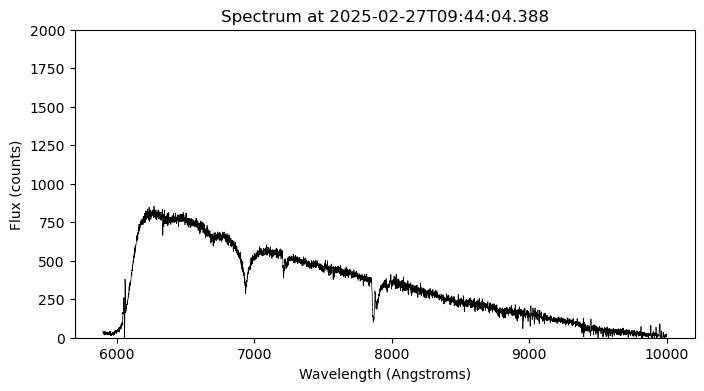

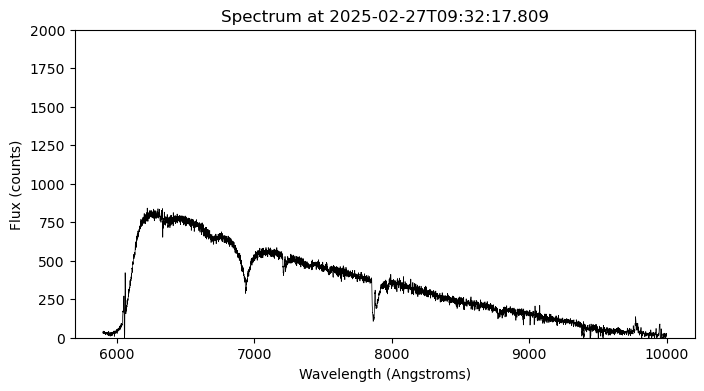

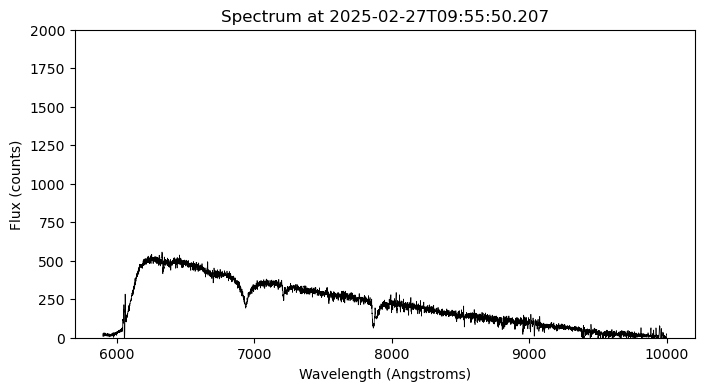

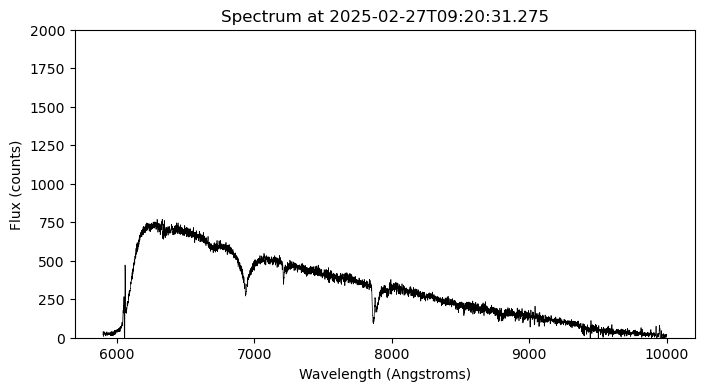

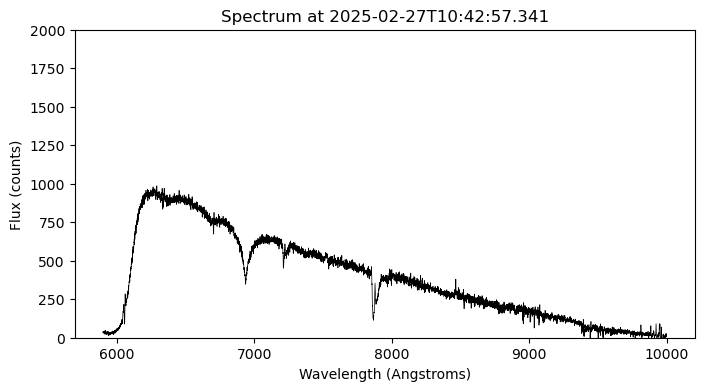

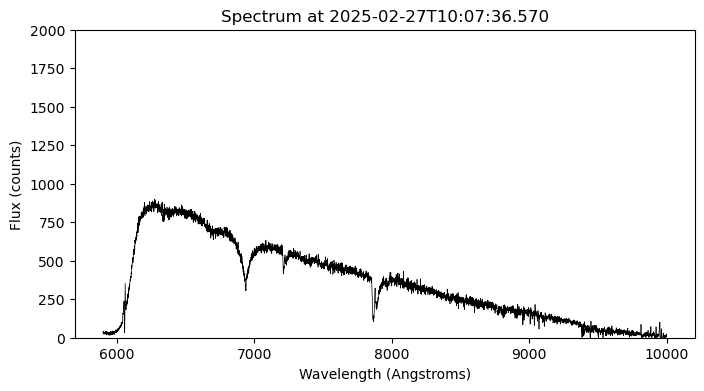

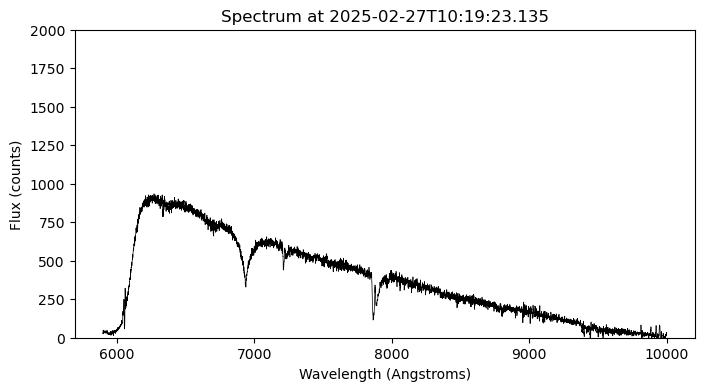

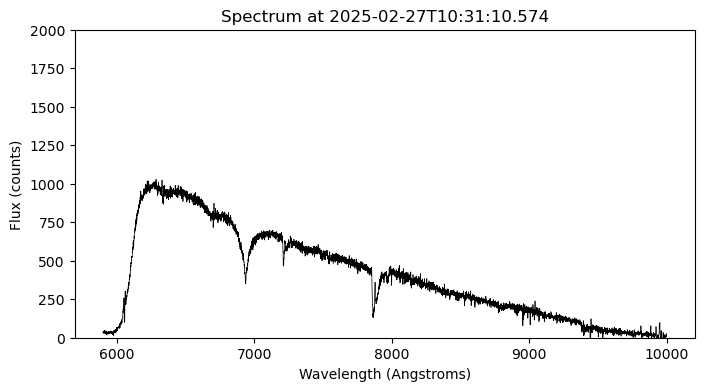

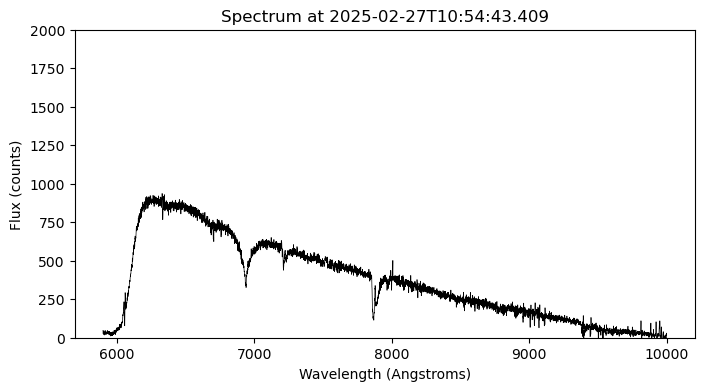

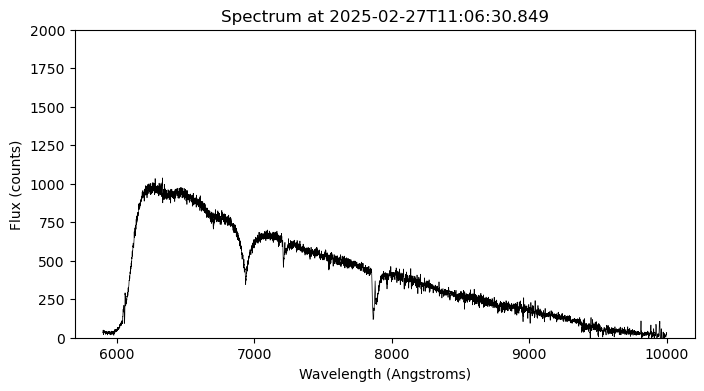

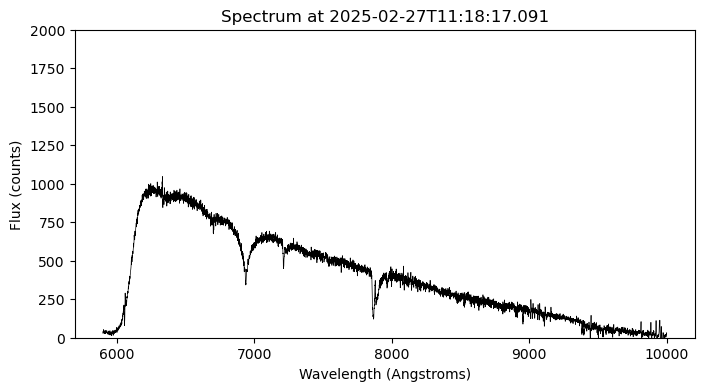

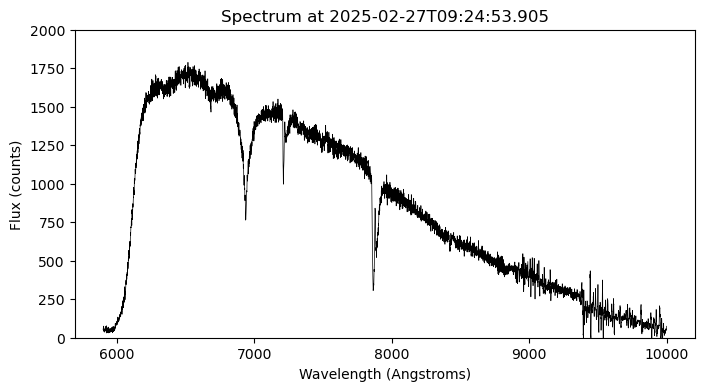

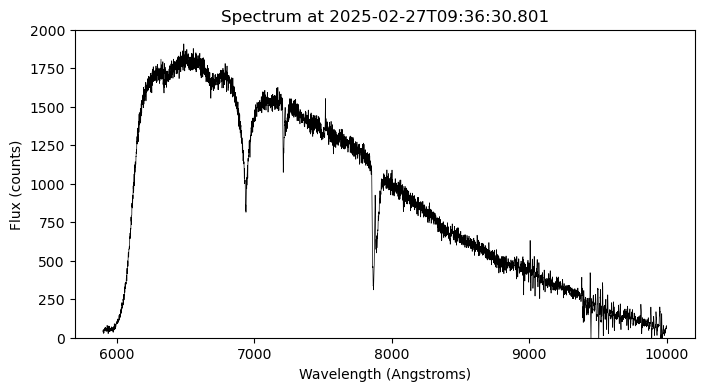

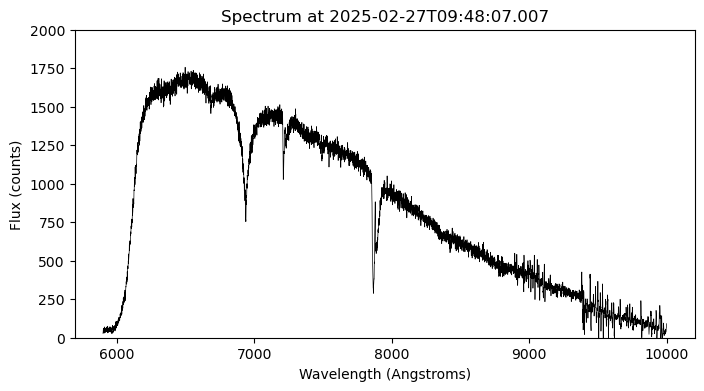

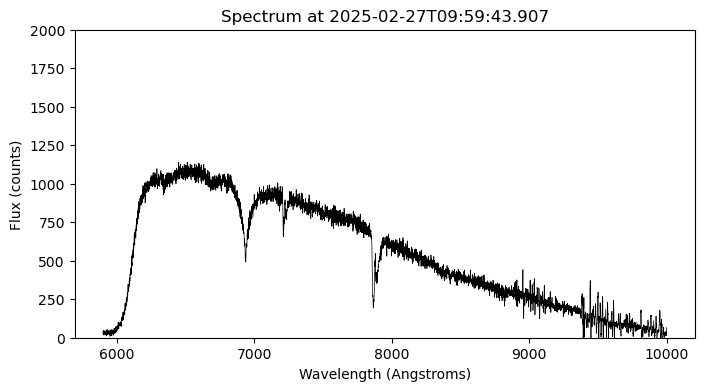

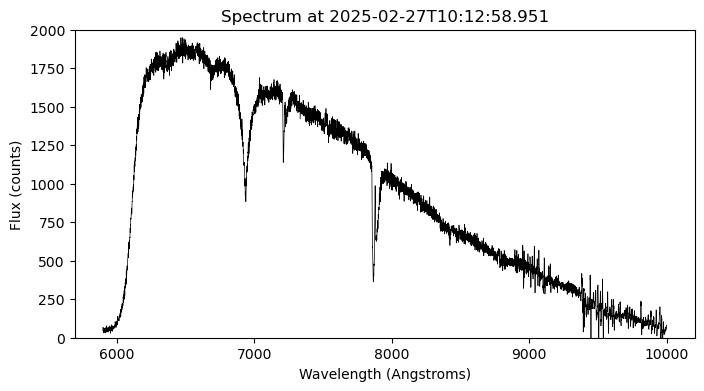

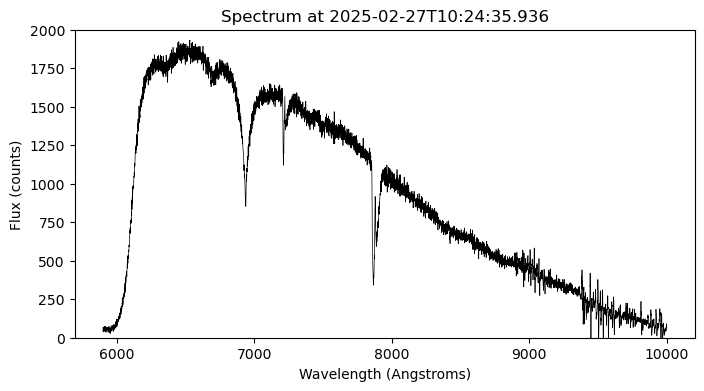

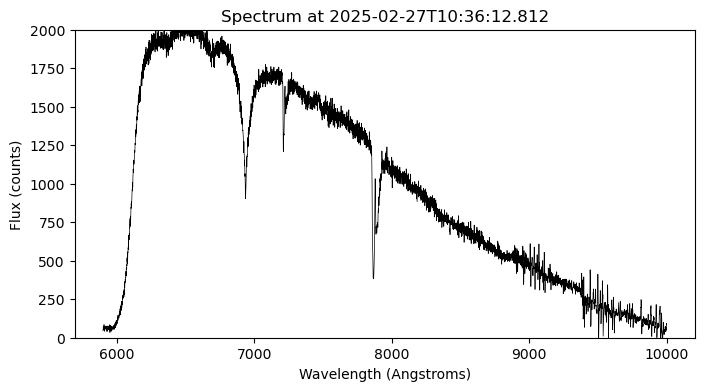

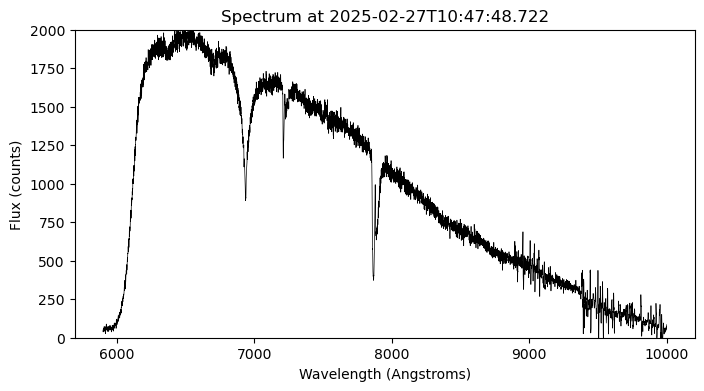

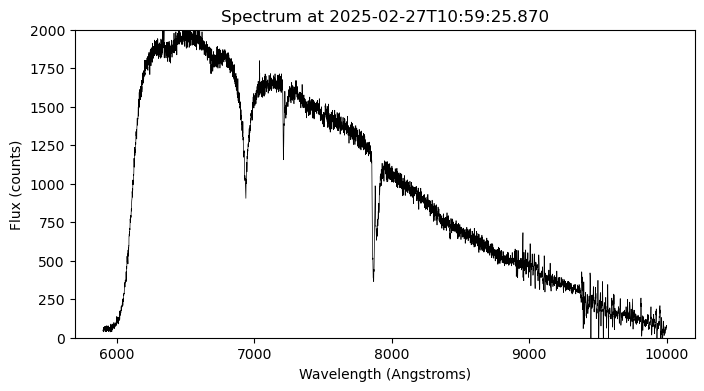

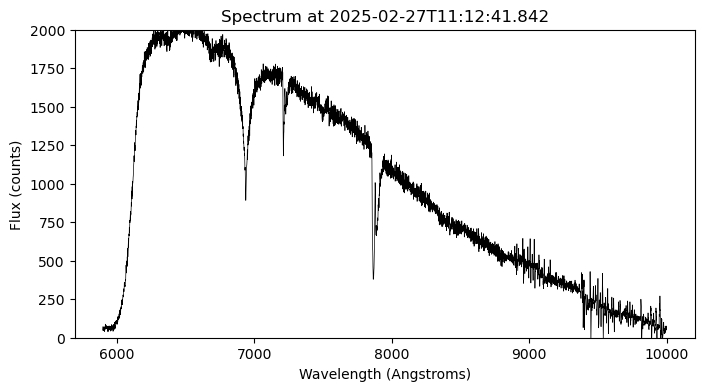

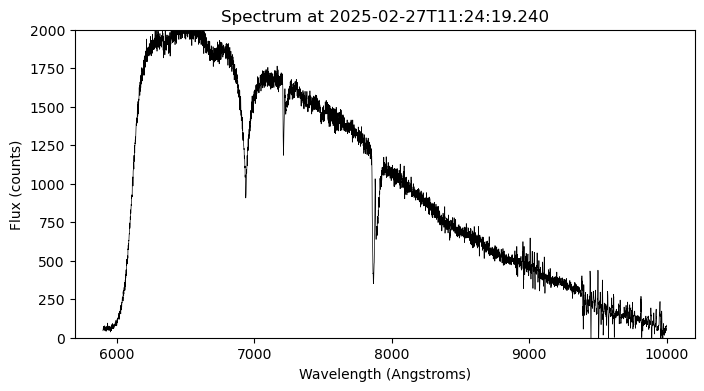

In [5]:
def process_zipped_fits_folder(zip_path):
    """
    Process all FITS files in a zipped folder and plot their spectra.

    Parameters:
        zip_path (str): path to the zipped folder containing the FITS files
    """
    import zipfile
    import io

    with zipfile.ZipFile(zip_path) as zipf:
        for filename in zipf.namelist():
            if filename.lower().endswith('.fits'):
                with zipf.open(filename) as file:
                    with fits.open(io.BytesIO(file.read())) as hdul:
                        load_and_plot_spectrum(hdul)


def load_and_plot_spectrum(hdul):
    """
    Loads a MODS FITS file, extracts the spectrum, and plots it.

    Parameters:
        filename (str): path to the FITS file
    """
    from astropy.io import fits
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from scipy.signal import medfilt
    from scipy.interpolate import interp1d

    # Open FITS file
    # print(hdul.info())
    hd = hdul['EXR'].header
    spec_data = hdul['EXR1D'].data
    spec_err_data = hdul['EXR1D_ERROR'].data
    
    # Select the spectrum with the highest mean flux because the index won't work for the specs of all the fits files
    mean_fluxes = [np.mean(s) for s in spec_data]
    best_index = np.argmax(mean_fluxes)
    spec = spec_data[best_index]
    spec_err = spec_err_data[best_index]

    # Get wavelength calibration info / Establish the wavelength solution
    wl_min = 5900
    wl_max = 10000
    n_wl = len(spec)
    wl = np.linspace(wl_min, wl_max, n_wl)

    filter_size = 5
    sigma_thresh = 3  # use 3 sigma to identify bad pixels
    # Apply a median filter to the spectrum
    spec_filt = medfilt(spec.astype(float), kernel_size=5)
    # Mark the pixels that are above the threshold
    bad_pix_mask = np.where((np.abs(spec - spec_filt) > sigma_thresh * spec_err))

    # Interpolate over the bad pixels
    good_pix_mask = np.ones(len(spec), dtype=bool)
    good_pix_mask[bad_pix_mask] = False
    interp_func = interp1d(wl[good_pix_mask], spec[good_pix_mask], bounds_error=False, fill_value='extrapolate')
    spec_fixed = spec.copy()
    spec_fixed[bad_pix_mask] = interp_func(wl[bad_pix_mask])


    # Show the spectrum after interpolation
    obs_time = hdul[0].header.get('DATE-OBS', 'Unknown Time')
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(wl, spec_fixed, color='black', lw=0.5)
    ax.set_ylim(0, 2000)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Flux (counts)')
    ax.set_title(f"Spectrum at {obs_time}")

process_zipped_fits_folder('red.zip')